Load required packages

In [61]:
import os
import cv2
import torch
import argparse
import datetime
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from model import VisionTransformer

Set hyperparameter

In [62]:
def hyperparameters():
    parser = argparse.ArgumentParser()
    
    # Test Arguments
    parser.add_argument("--batch_size", type=int, default=128)
    parser.add_argument("--num_workers", type=int, default=2)
    parser.add_argument("--device", type=str, default="mps", choices=["cpu", "cuda", "mps"])
    parser.add_argument("--output_path", type=str, default='./output')
    parser.add_argument("--timestamp", type=str, default="1900-01-01-00-00")
    parser.add_argument("--mode", type=str, default="cifar", choices=['cifar', 'single-cifar', 'custom'])
    parser.add_argument("--no_image", default=False, action='store_true')

    # Data Arguments
    parser.add_argument("--image_size", type=int, default=32)
    parser.add_argument("--n_channels", type=int, default=3)
    parser.add_argument("--patch_size", type=int, default=4)
    parser.add_argument("--n_classes", type=int, default=10)
    parser.add_argument("--data_path", type=str, default='./data')
    parser.add_argument("--num_test_images", type=int, default=None)
    parser.add_argument("--index", type=int, default=9)
    parser.add_argument("--image_path", type=str, default=None)

    # ViT Arguments
    parser.add_argument("--embed_dim", type=int, default=128)
    parser.add_argument("--n_layers", type=int, default=6)
    parser.add_argument("--n_attention_heads", type=int, default=4)
    parser.add_argument("--forward_mul", type=int, default=2)
    parser.add_argument("--dropout", type=int, default=0.1)
    parser.add_argument("--model_path", type=str, default='model/vit-patch4-embed128-head4-32-cifar10/vit-patch4-embed128-head4-32-cifar10-199.pt')

    args = parser.parse_args("") # https://stackoverflow.com/a/69925856
    return args

args = hyperparameters()

Set CIFAR-10 classes

In [63]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Get image and label

In [64]:
transform = transforms.Compose([
        transforms.Resize([args.image_size, args.image_size]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
testset = torchvision.datasets.CIFAR10(root=args.data_path, train=False, 
                                        download=True, transform=transform)

image, label = testset.__getitem__(args.index)
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

Files already downloaded and verified
Image shape: torch.Size([3, 32, 32])
Label: 1


Show image and label

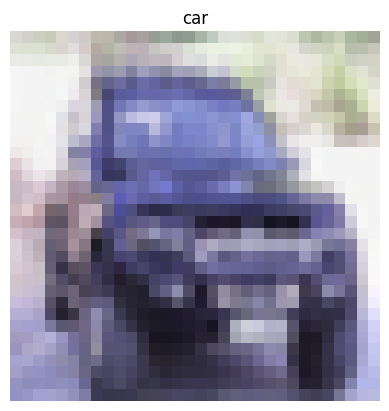

In [65]:
img = (image / 2 + 0.5).permute(1, 2, 0).numpy() # (c, h, w) -> (h, w, c)
plt.imshow(img)
plt.title(classes[label])
plt.axis('off')
plt.show()

Prepare Vision Transformer model

In [66]:
model = VisionTransformer(args.n_channels, args.embed_dim, args.n_layers, 
                              args.n_attention_heads, args.forward_mul, args.image_size, 
                              args.patch_size, args.n_classes, args.dropout)
model.load_state_dict(torch.load(args.model_path, weights_only=True, map_location=args.device))
model.eval()
print(model)

VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=128, out_features=128, bias=True)
        (keys): Linear(in_features=128, out_features=128, bias=True)
        (values): Linear(in_features=128, out_features=128, bias=True)
        (out_projection): Linear(in_features=128, out_features=128, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=128, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=256, out_features=128, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, 

Pass image through ViT model

In [67]:
logits, att_mat = model(image.unsqueeze(0))
print(logits)
print(att_mat.shape)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), (img.shape[0], img.shape[1]))[..., np.newaxis]
result = (mask * img)

tensor([[-0.2379,  2.3441,  0.1502, -1.1114, -0.8891, -1.0353, -0.3303, -0.3085,
         -1.1623,  1.3552]], grad_fn=<AddmmBackward0>)
torch.Size([6, 4, 65, 65])


Prediction Label and Attention Map!

0.54537 : car
0.20288 : truck
0.06080 : bird
0.04124 : plane
0.03843 : horse
0.03760 : frog
0.02151 : deer
0.01858 : dog
0.01722 : cat
0.01636 : ship


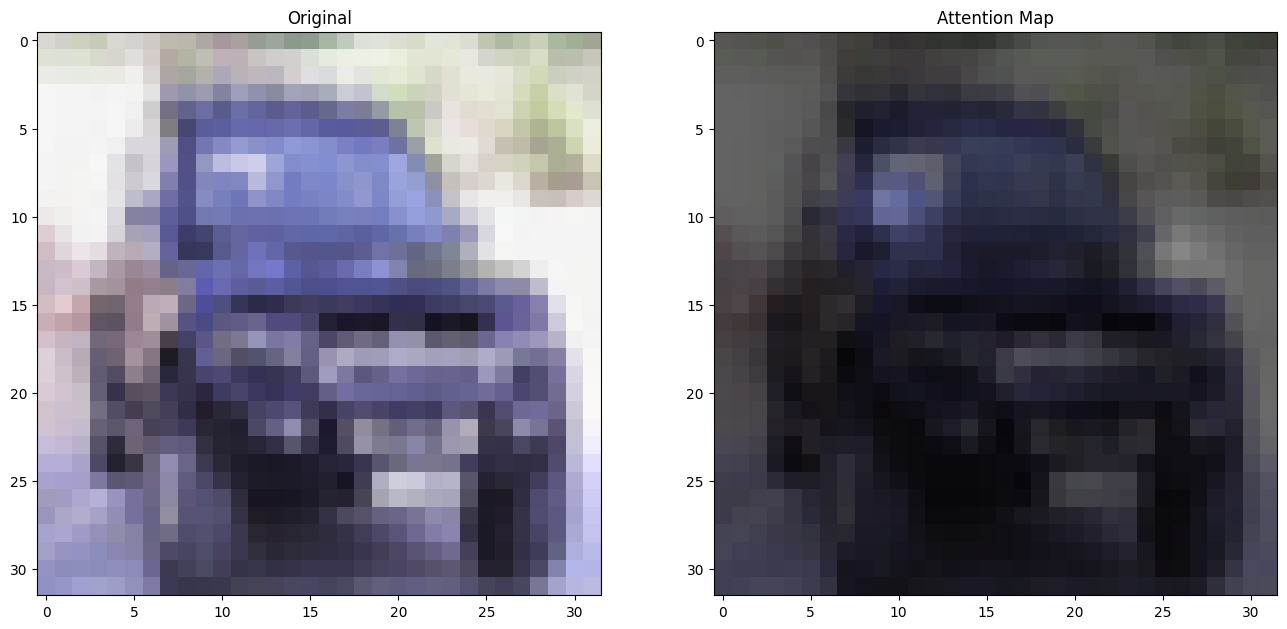

In [68]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :10]:
    print(f'{probs[0, idx.item()]:.5f} : {classes[idx.item()]}\n', end='')

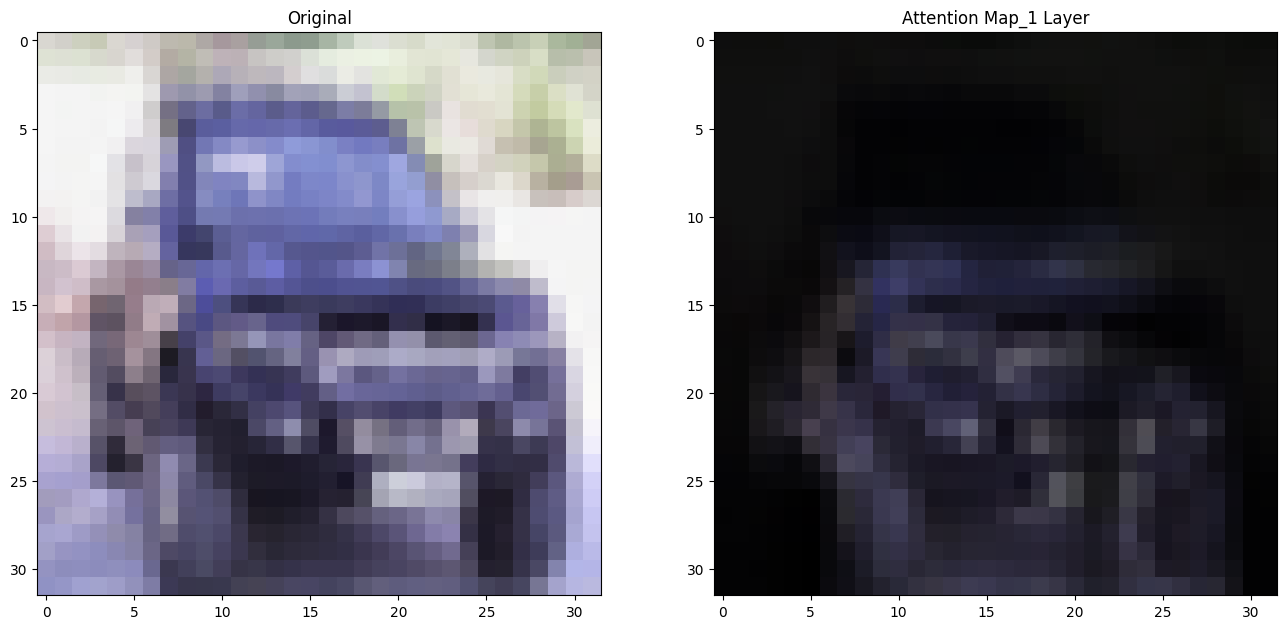

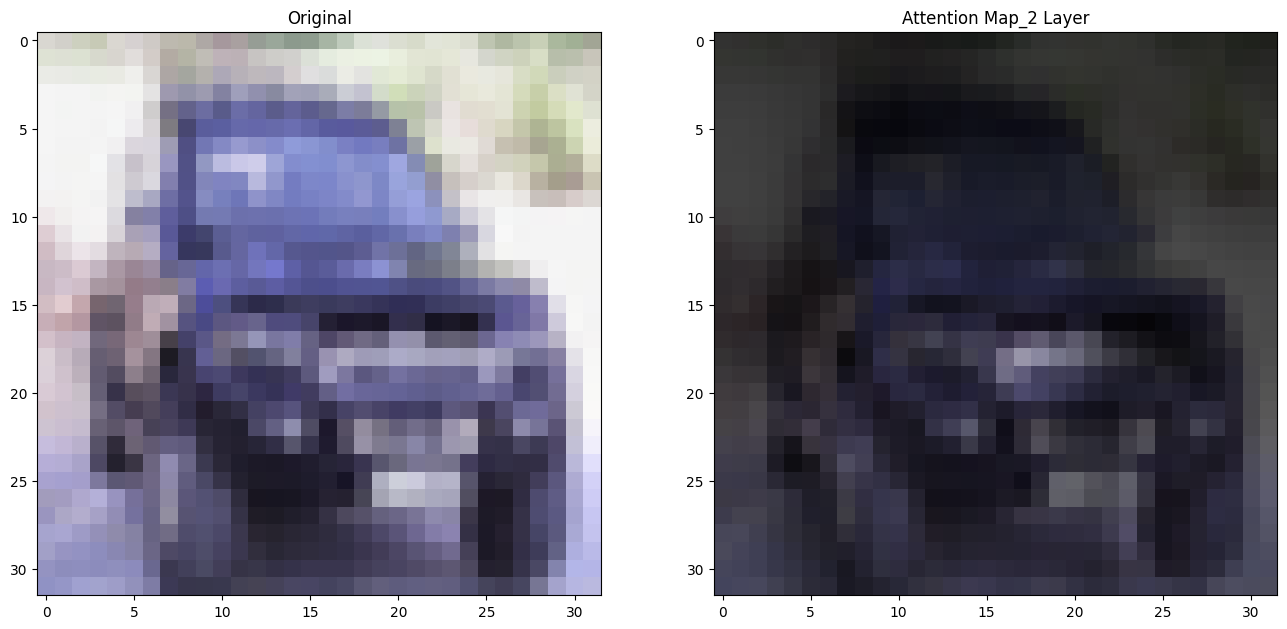

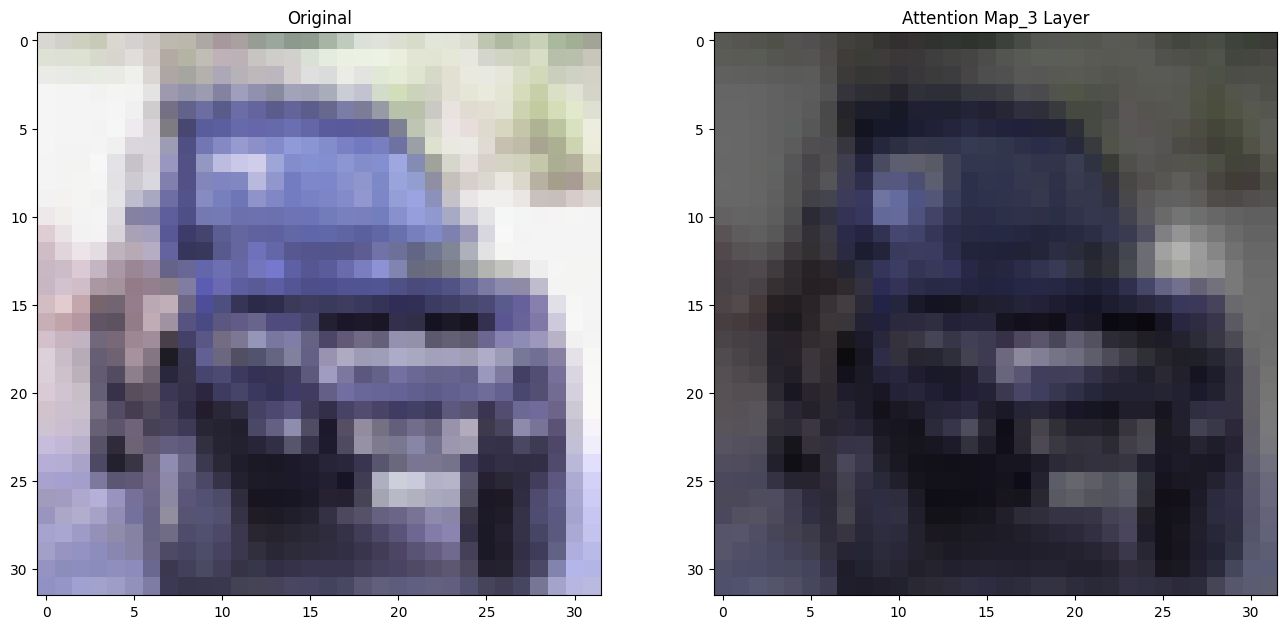

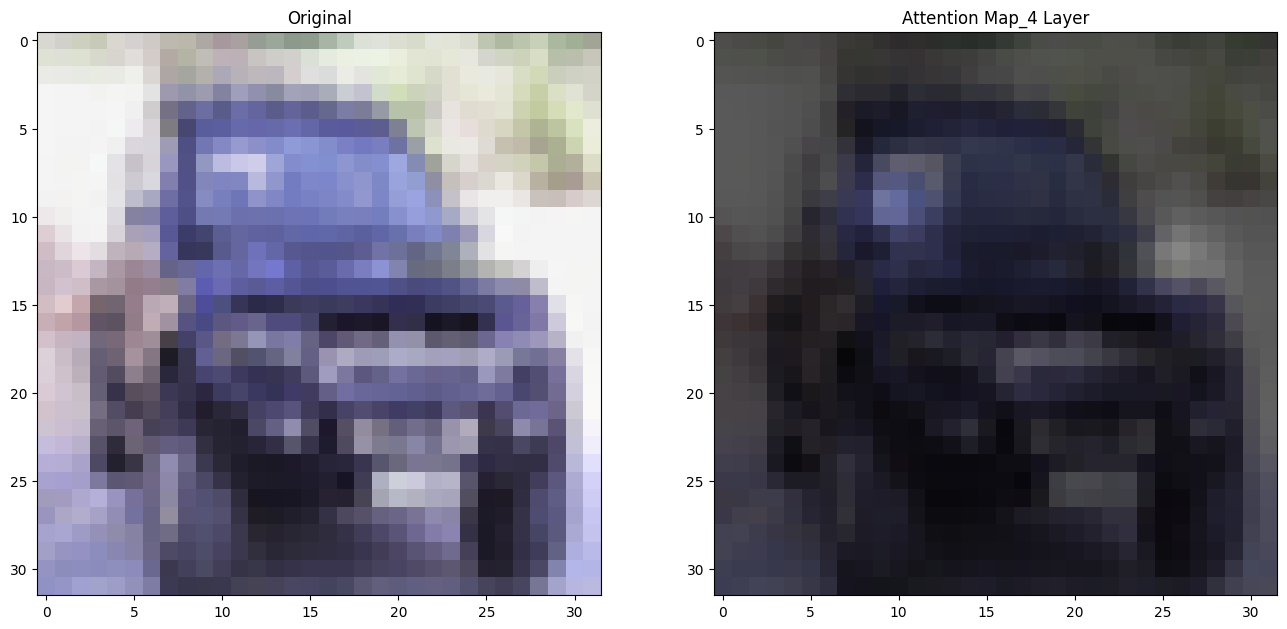

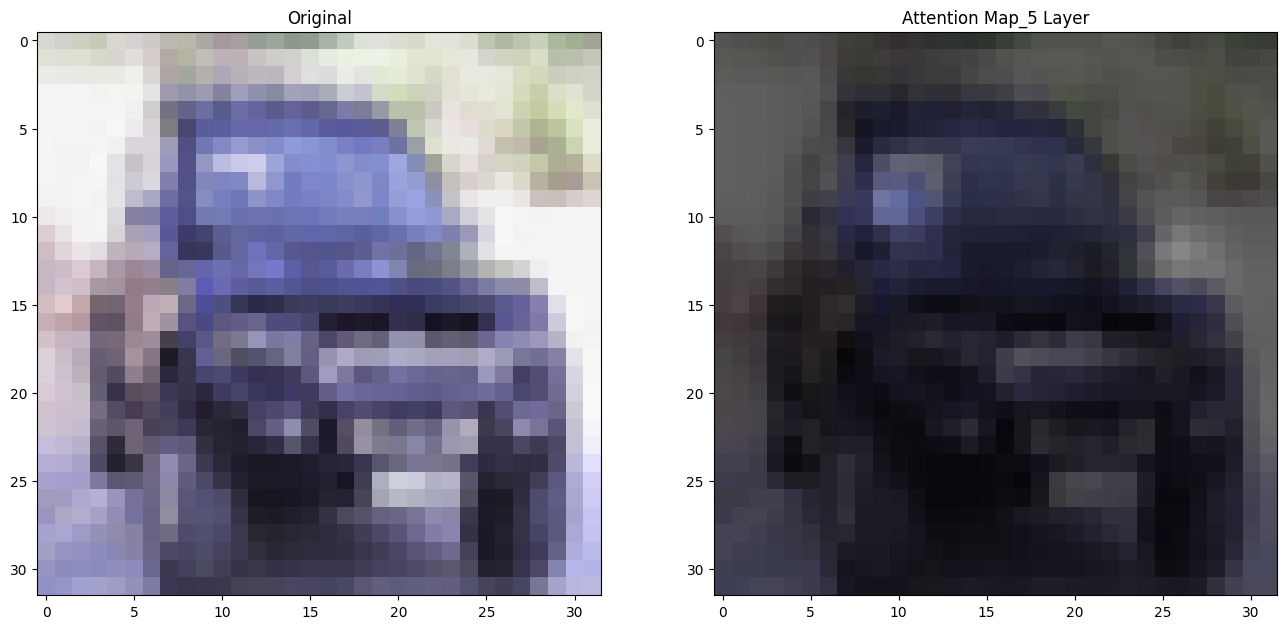

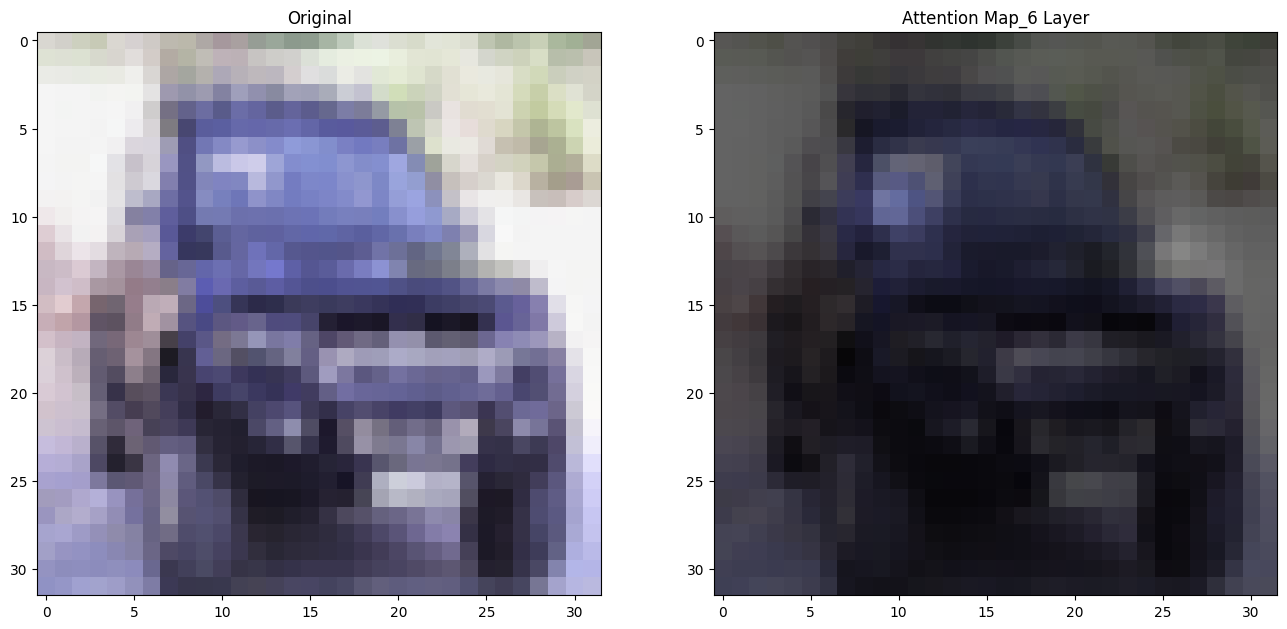

In [69]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), (img.shape[0], img.shape[1]))[..., np.newaxis]
    result = (mask * img)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(img)
    _ = ax2.imshow(result)